In [ ]:
# 1.Importing necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import random
from sklearn.model_selection import train_test_split
from cvxopt import matrix, solvers
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn import preprocessing
from collections import Counter
warnings.filterwarnings('ignore')

In [ ]:
# 2.Importing the required dataset
data = pd.read_csv('/content/iris_dirty1.csv')
print(data.columns)

Index(['Unnamed: 0', 'Sepal.Length', 'Sepal.Width', 'Petal.Length',
       'Petal.Width', 'Species'],
      dtype='object')


In [ ]:
# 3.First five rows of dataset
data.head()

,Unnamed: 0,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,Setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,NaN,3.6,1.4,0.2,setosa


In [ ]:
# 4.Dataset Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    150 non-null    int64  
 1   Sepal.Length  142 non-null    float64
 2   Sepal.Width   139 non-null    float64
 3   Petal.Length  150 non-null    float64
 4   Petal.Width   150 non-null    float64
 5   Species       150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [ ]:
# 5.Checking null values
data.isnull().sum()

,0
Unnamed: 0,0
Sepal.Length,8
Sepal.Width,11
Petal.Length,0
Petal.Width,0
Species,0


In [ ]:
# 6.Filling missing values with mean
data['Sepal.Length'].fillna(data['Sepal.Length'].mean(), inplace=True)
data['Sepal.Width'].fillna(data['Sepal.Width'].mean(), inplace=True)

In [ ]:
# 7.Checking shape of dataset and DataTypes of columns
print(f"Shape of dataset is : {data.shape}")
data.dtypes

Shape of dataset is : (150, 6)


,0
Unnamed: 0,int64
Sepal.Length,float64
Sepal.Width,float64
Petal.Length,float64
Petal.Width,float64
Species,object


In [ ]:
# 8.Dropping Unnamed: 0 column and lowercasing species column
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data['Species'] = data['Species'].str.lower()

In [ ]:
# 9.First five rows of dataset after cleaning data
data.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.100000,3.5,1.4,0.2,setosa
1,4.900000,3.0,1.4,0.2,setosa
2,4.700000,3.2,1.3,0.2,setosa
3,4.600000,3.1,1.5,0.2,setosa
4,5.840141,3.6,1.4,0.2,setosa


In [ ]:
# 10.Statistical summary of dataset
data.describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.840141,3.043165,3.758000,1.199333
std,0.809263,0.422052,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


<Axes: >

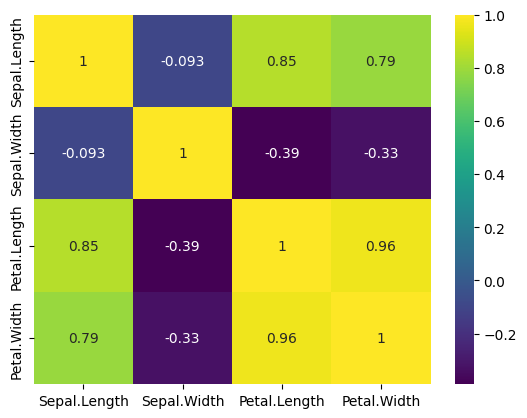

In [ ]:
# 11.Correlation heatmap
sns.heatmap(data.corr(numeric_only=True), cmap='viridis', annot= True )

In [ ]:
# 12.Encoding species and splitting data into train and test sets
label_encoder = preprocessing.LabelEncoder()
data['Species']= label_encoder.fit_transform(data['Species'])
target_var= data['Species']
feature_set=data.drop(['Species'], axis=1)
feature_set=feature_set.iloc[:,:2]
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(feature_set,target_var,test_size =
0.2,random_state =4)

In [ ]:
# 13.Convert Train and Test sets to numpy arrays
X_train=X_train.values
Y_train=Y_train.values
X_test=X_test.values
Y_test=Y_test.values

In [ ]:
# 14.Implementation of Binary svm
class BinarySVM:
    def __init__(self, reg_par=1.0, gamma=0.5):
        self.reg_par = reg_par  # regularization parameter
        self.gamma = gamma      # complexity of boundaries
        self.weights = None     # weights
        self.support_vectors = None
        self.labels_sv = None
        self.bias = 0
    def rbf_kernel(self, x1, x2):
        return np.exp(-self.gamma * np.linalg.norm(x1 - x2) ** 2)
    def compute_kernel_matrix(self, X):
        n = X.shape[0]
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                K[i, j] = self.rbf_kernel(X[i], X[j])
        return K
    def fit(self, features, y):
        m, n = features.shape
        K = self.compute_kernel_matrix(features)

        P = matrix(np.outer(y, y) * K)
        q = matrix(-np.ones(m))
        G = matrix(np.vstack((-np.eye(m), np.eye(m))))
        h = matrix(np.hstack((np.zeros(m), np.ones(m) * self.reg_par)))
        A = matrix(y.reshape(1, -1).astype('double'))
        bias = matrix(0.0)
        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, bias)
        self.weights = np.ravel(solution['x'])
        sv = self.weights > 1e-5
        self.weights = self.weights[sv]
        self.support_vectors = features[sv]
        self.labels_sv = y[sv]
        self.bias = np.mean([
            y_k - np.sum(self.weights * self.labels_sv * K[i][sv])
            for i, y_k in enumerate(y[sv])
        ])
    # Compute decision function
    def project(self, features):
        result = np.zeros(features.shape[0])
        for i, x in enumerate(features):
            result[i] = np.sum([
                self.weights[j] * self.labels_sv[j] * self.rbf_kernel(x, self.support_vectors[j])
                for j in range(len(self.weights))
            ]) + self.bias
        return result

    def predict(self, features):
        return np.sign(self.project(features))

In [ ]:
# 15.Implementation of Multiclass svm
class MultiClassSVM:
    def __init__(self, reg_par=1.0, gamma=0.5):
        self.reg_par = reg_par
        self.gamma = gamma
        self.classifiers = {}
    def fit(self, features, target):
        classes = np.unique(target)
        self.class_pairs = [(i, j) for i in classes for j in classes if i < j]
        for (class_i, class_j) in self.class_pairs:
            X_binary = features[(target == class_i) | (target == class_j)]
            y_binary = target[(target == class_i) | (target == class_j)]
            y_binary = np.where(y_binary == class_i, 1, -1)
            svm = BinarySVM(reg_par=self.reg_par, gamma=self.gamma)
            svm.fit(X_binary, y_binary)
            self.classifiers[(class_i, class_j)] = svm
    def predict(self, features):
        votes = np.zeros((features.shape[0], len(self.classifiers)))
        for k, ((class_i, class_j), svm) in enumerate(self.classifiers.items()):
            prediction = svm.predict(features)
            votes[:, k] = np.where(prediction == 1, class_i, class_j)
        value_predicted = [
            Counter(votes[i]).most_common(1)[0][0]
            for i in range(features.shape[0])
        ]
        return np.array(value_predicted)
    def evaluate(self, X_test, Y_test):
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        classes = np.unique(Y_test)
        precision = precision_score(Y_test, y_pred, average=None, labels=classes, zero_division=0)
        recall = recall_score(Y_test, y_pred, average=None, labels=classes, zero_division=0)
        overall_precision = precision_score(Y_test, y_pred, average='macro', zero_division=0)
        overall_recall = recall_score(Y_test, y_pred, average='macro', zero_division=0)
        precision_recall = {
            int(c): (round(float(p), 2), round(float(r), 2))
            for c, p, r in zip(classes, precision, recall)
        }
        results = {
        "accuracy": round(float(accuracy), 2),
        "overall_precision": round(float(overall_precision), 2),
        "overall_recall": round(float(overall_recall), 2),
        "per_class": precision_recall
        }
        return results
    def plot_decision_boundary(self, features, label):
        x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
        y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(grid_points)
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
        plt.scatter(features[:, 0], features[:, 1],
                    c=label, edgecolors='k', cmap=plt.cm.coolwarm)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title("SVM Decision Boundary for Multiclass Classification")
        plt.show()


In [ ]:
# 16.Train and evaluate multiclass svm model
multi_svm = MultiClassSVM(reg_par=1.0, gamma=0.5)
multi_svm.fit(X_train, Y_train)

results = multi_svm.evaluate(X_test, Y_test)

print(f"Accuracy: {results['accuracy']}")
print(f"Overall Precision: {results['overall_precision']}")
print(f"Overall Recall: {results['overall_recall']}")

Accuracy: 0.83
Overall Precision: 0.81
Overall Recall: 0.86


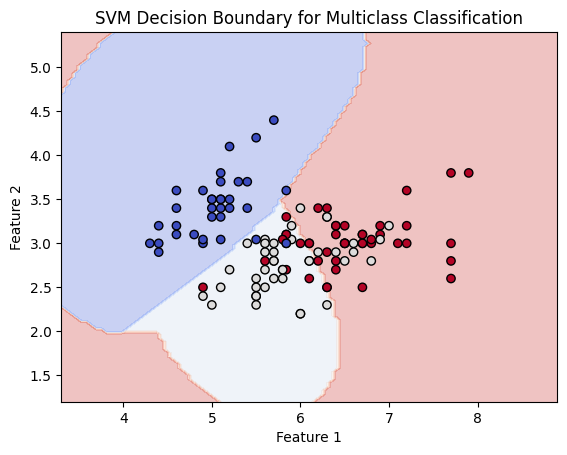

In [ ]:
# 17.Plot decision boundary for multiclass svm
multi_svm.plot_decision_boundary(X_train, Y_train)